In [1]:
import numpy as np 
import pandas as pd 
import h5py
import glob
import time
import os
import sys

from scipy.interpolate import interp1d

import matplotlib.pylab as plt

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua4 as eua

!module load odc
import pyodc
import codc



Loading odc/1.4.5-gcc-11.3.0-avoxopw
  Loading requirement: openmpi/4.0.5-gcc-11.3.0-pob76hu
    eckit/1.24.4-gcc-11.3.0-jxjc4by
>

In [2]:
sel_dt = '202301'
sel_statid = '11035'

# Loading data from the era5 file:

bg_files = glob.glob('/mnt/users/scratch/leo/scratch/era5/odbs/1/*'+sel_dt+'*'+sel_statid+'')[0]
df_decoded = codc.read_odb(bg_files, single=True)
subset = df_decoded[['vertco_type@body', 'vertco_reference_1@body', 'andate', 'antime', 'obsvalue@body', 'varno@body', 'fg_depar@body', 'biascorr@body']]
temp_data = subset[subset['varno@body'] == 2]
z_data = subset[subset['varno@body'] == 1]
z_data = z_data[['vertco_reference_1@body', 'andate', 'antime', 'obsvalue@body']]
z_data.rename(columns={'obsvalue@body': 'gpm'}, inplace=True)
temp_data['temp_final'] = temp_data['obsvalue@body'] - temp_data['fg_depar@body'] - temp_data['biascorr@body']
era_df = temp_data.merge(z_data, on=['vertco_reference_1@body', 'andate', 'antime'])

# Loading data from the converted file:

cfile = glob.glob('/mnt/users/scratch/leo/scratch/converted_v25/long/*'+sel_statid+'*.nc')[0]
cdmfile = eua.CDMDataset(cfile)
df = cdmfile.to_dataframe(groups = ['observations_table'], variables= ['date_time', 'observation_value', 'observed_variable', 'z_coordinate'])
df = df[df.observed_variable == 117]

/srvfs/home/uvoggenberger/.local/lib/python3.10/site-packages/codc/frame.py:329: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df.dtypes[0] == np.int64:
/srvfs/home/uvoggenberger/.local/lib/python3.10/site-packages/codc/frame.py:329: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df.dtypes[0] == np.int64:
/srvfs/home/uvoggenberger/.local/lib/python3.10/site-packages/codc/frame.py:331: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

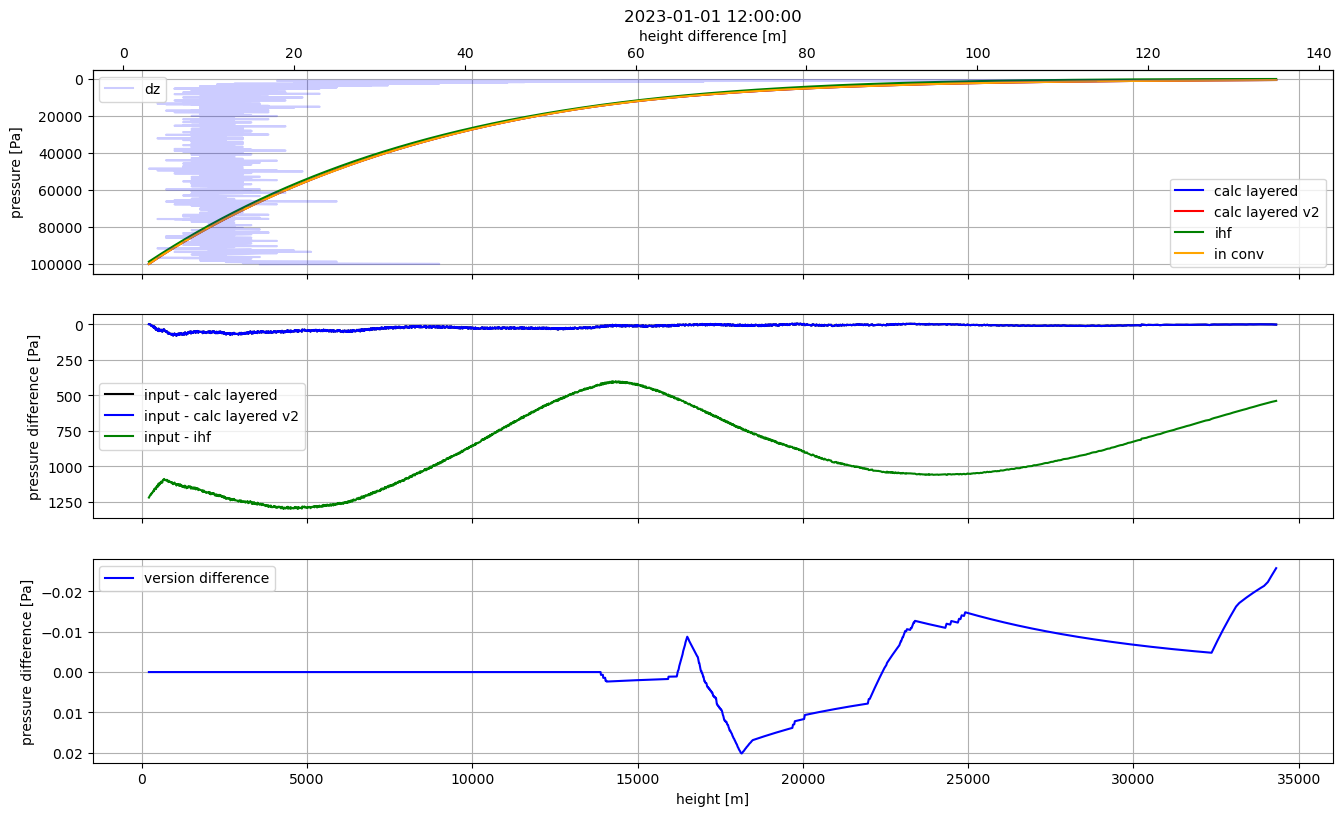

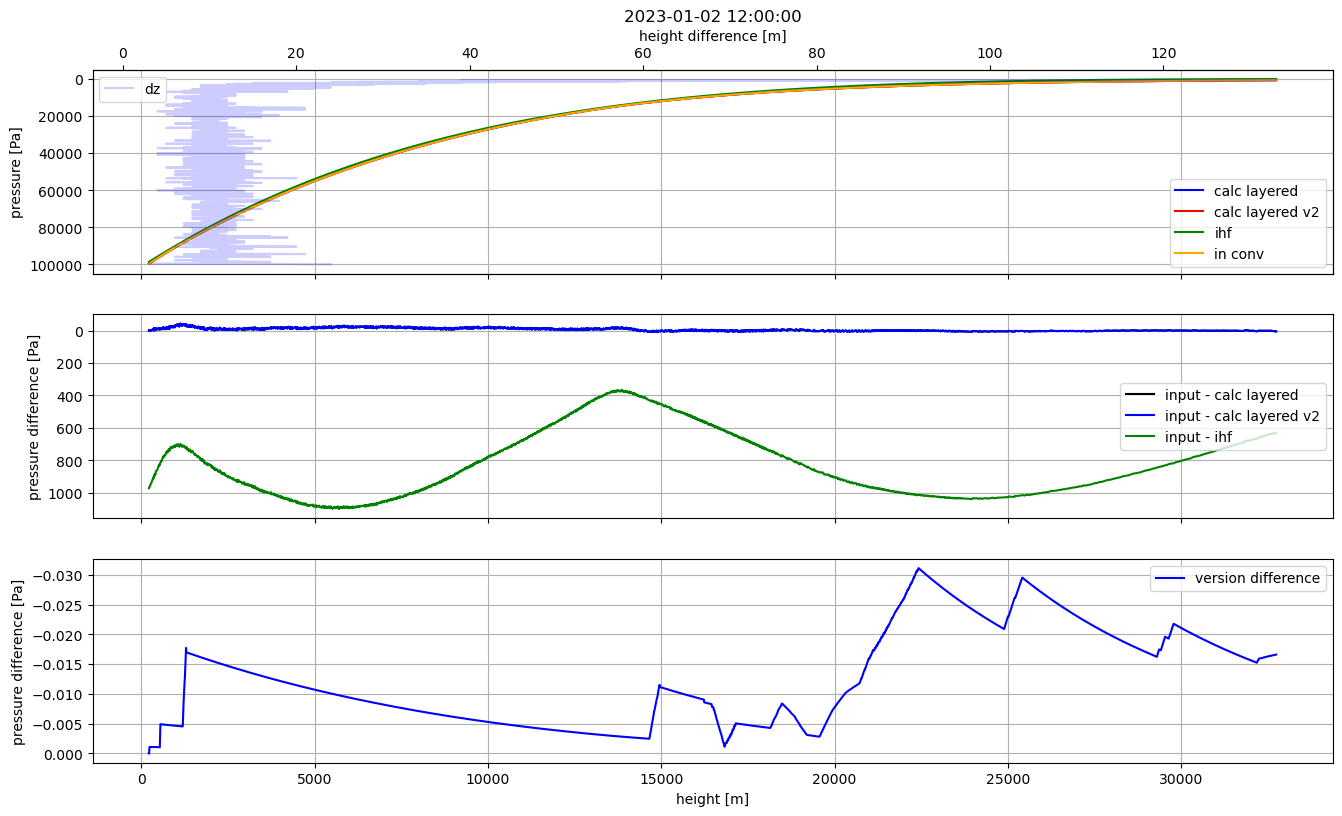

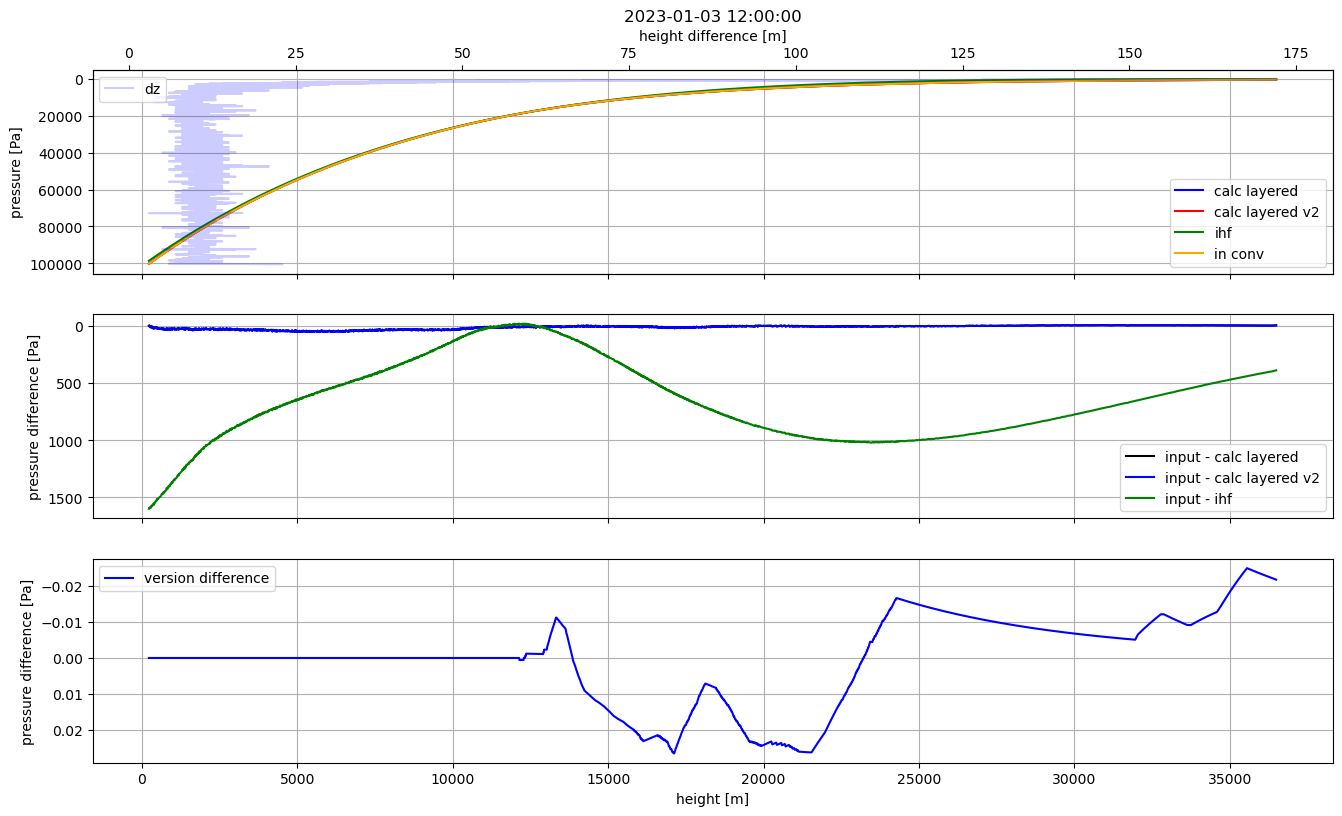

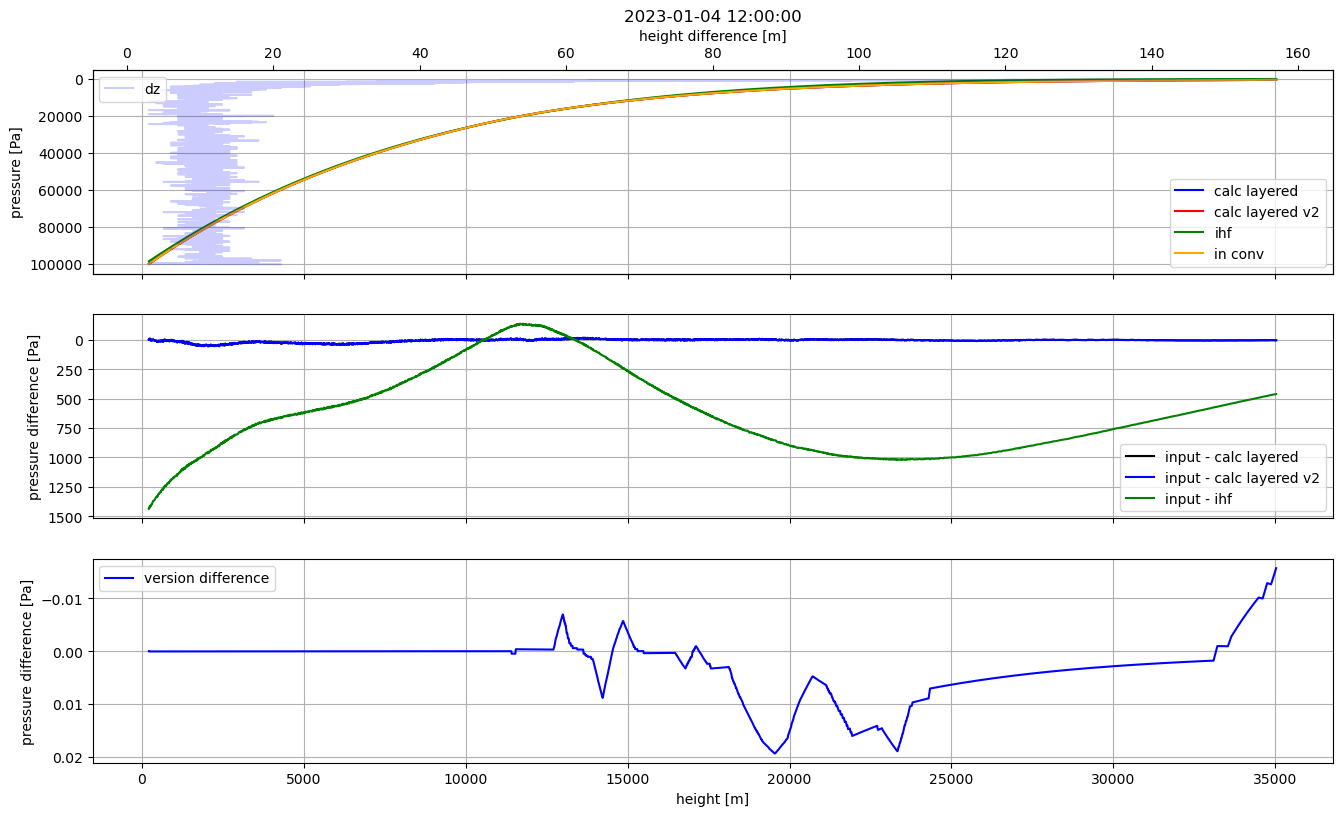

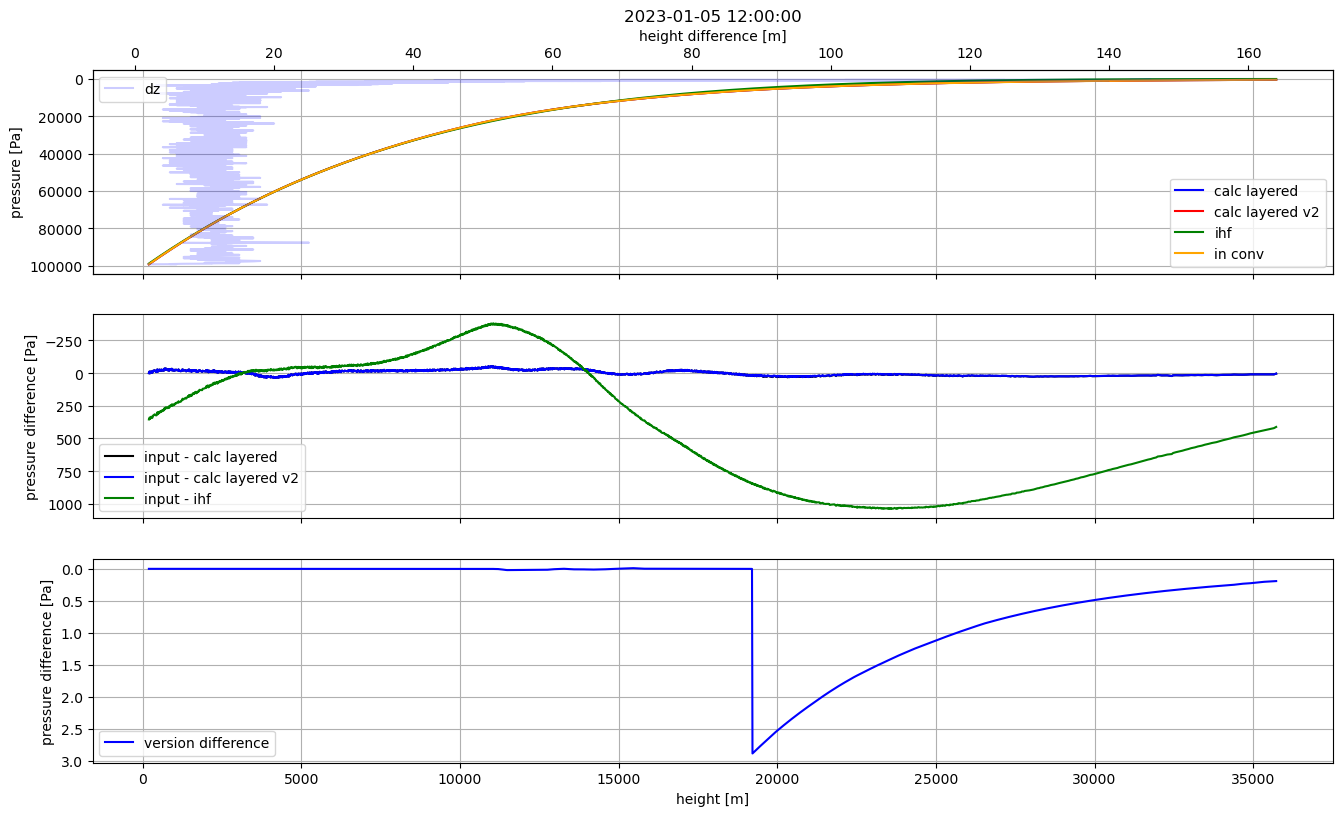

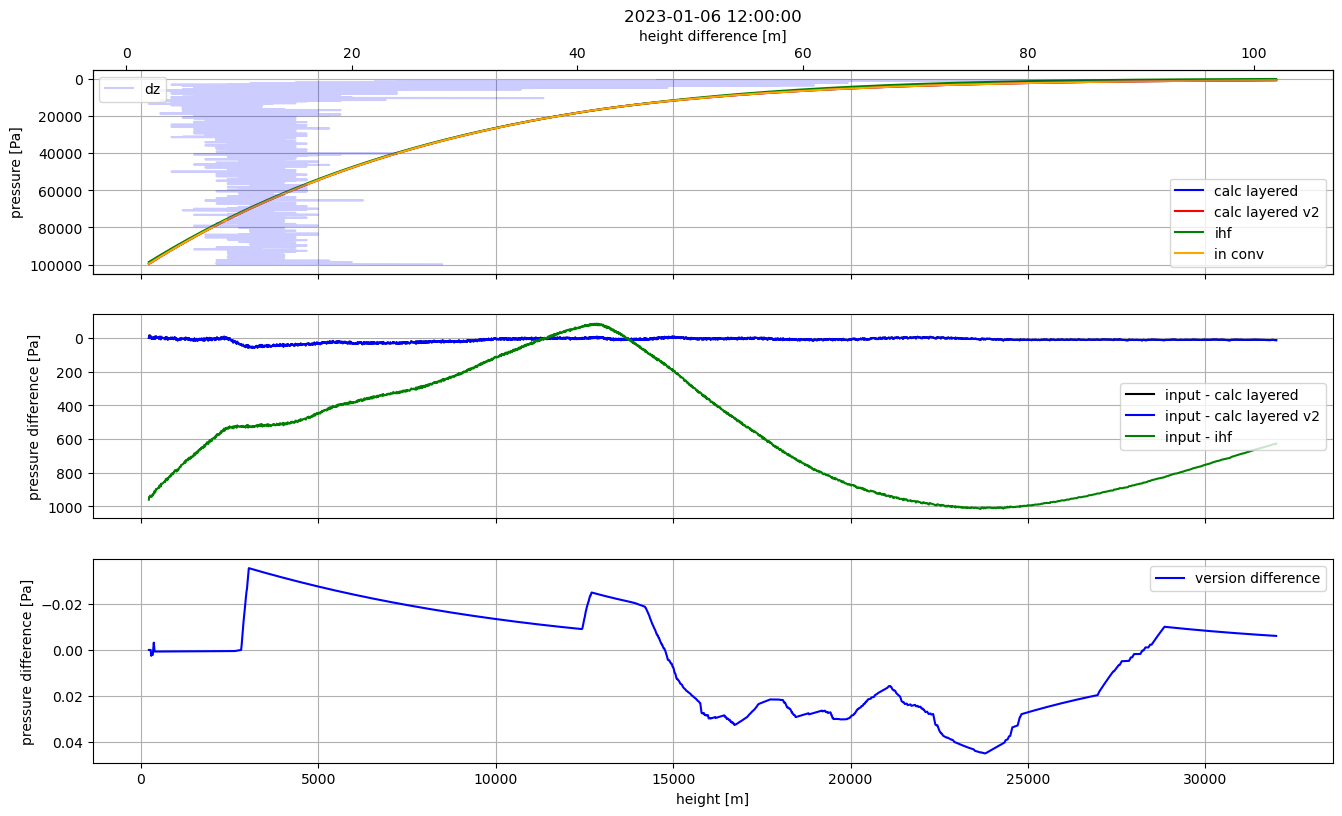

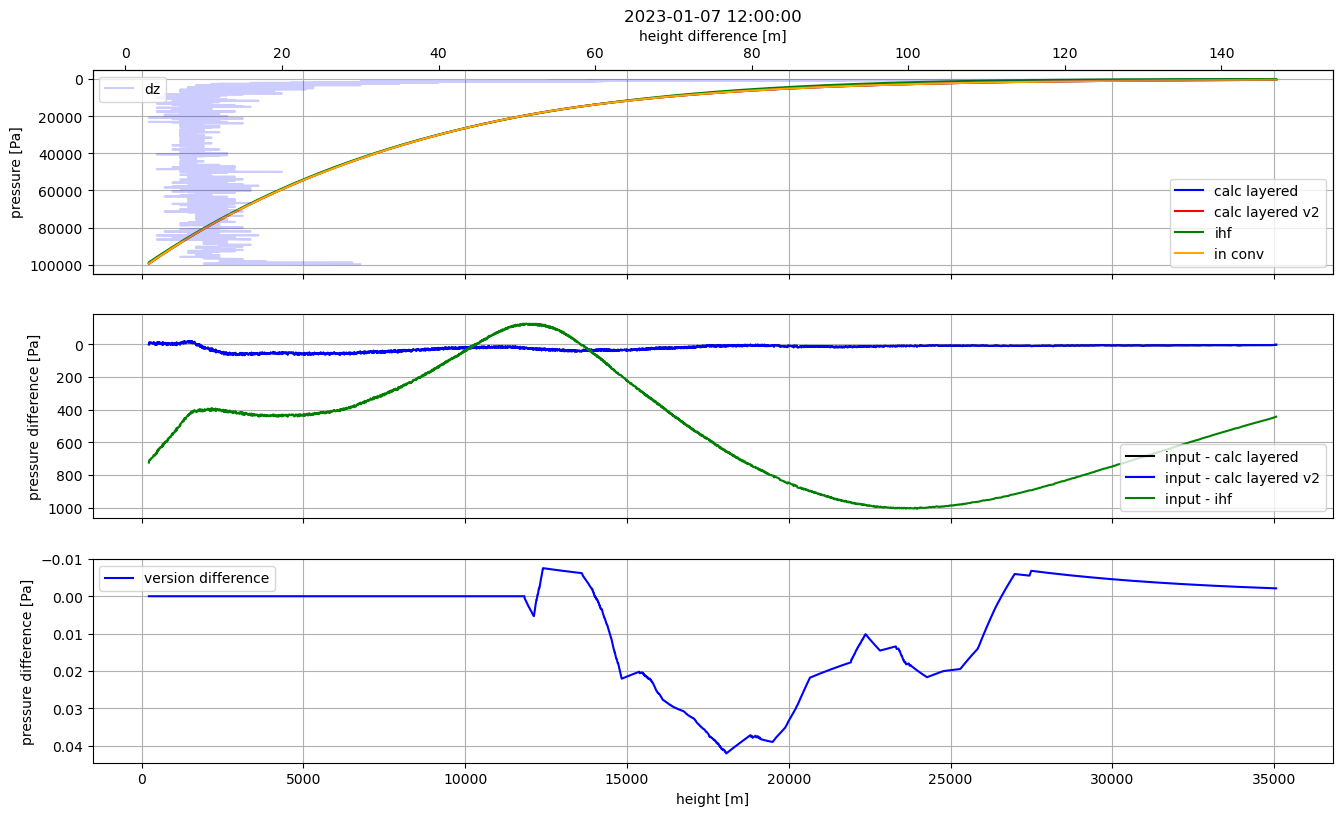

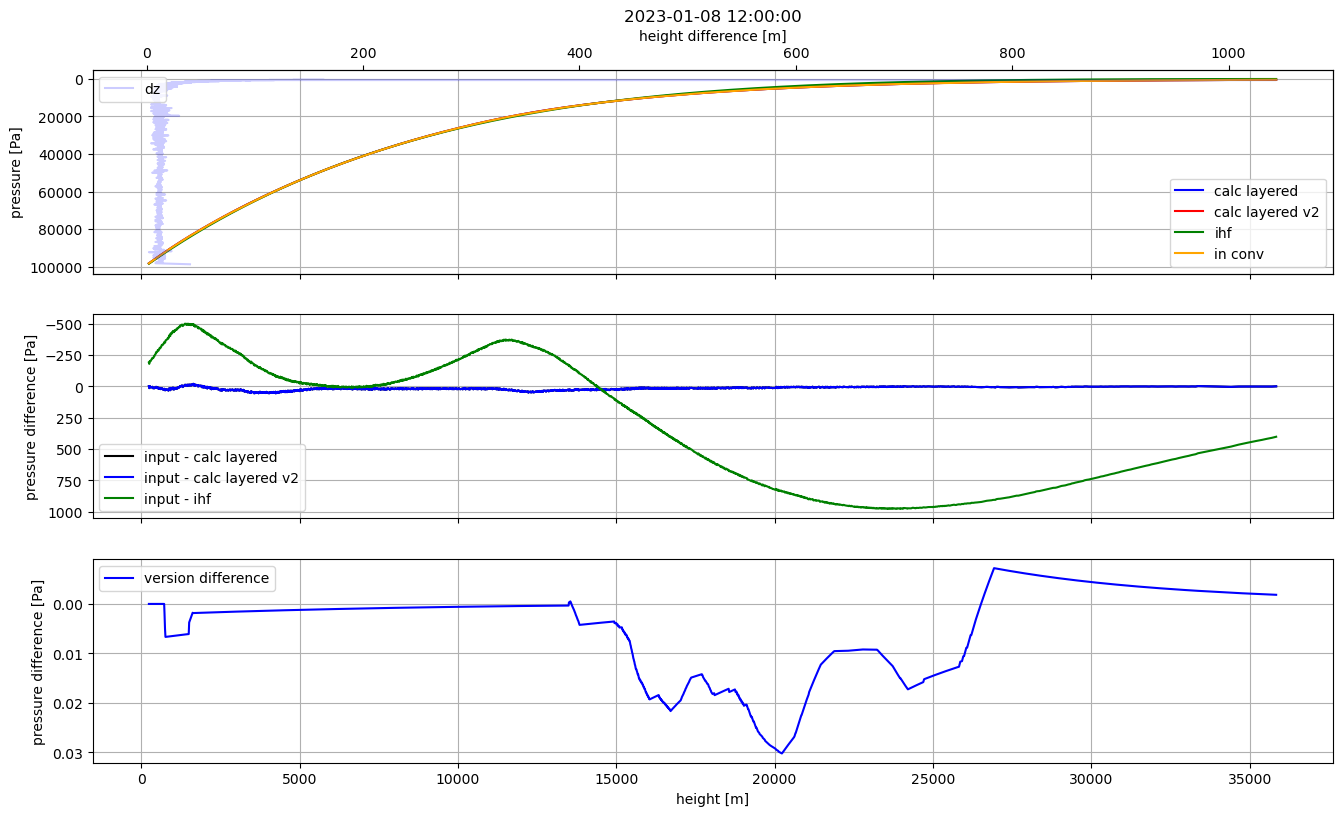

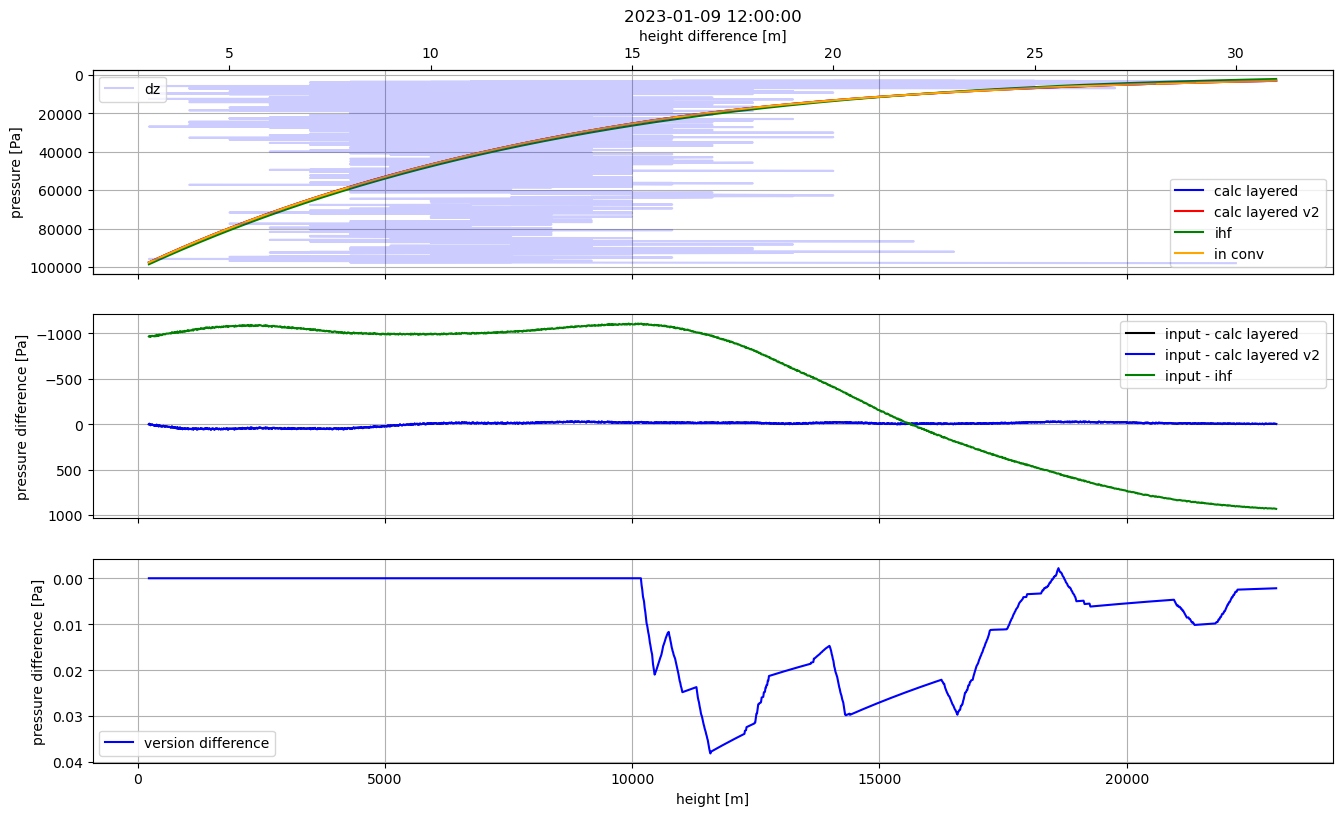

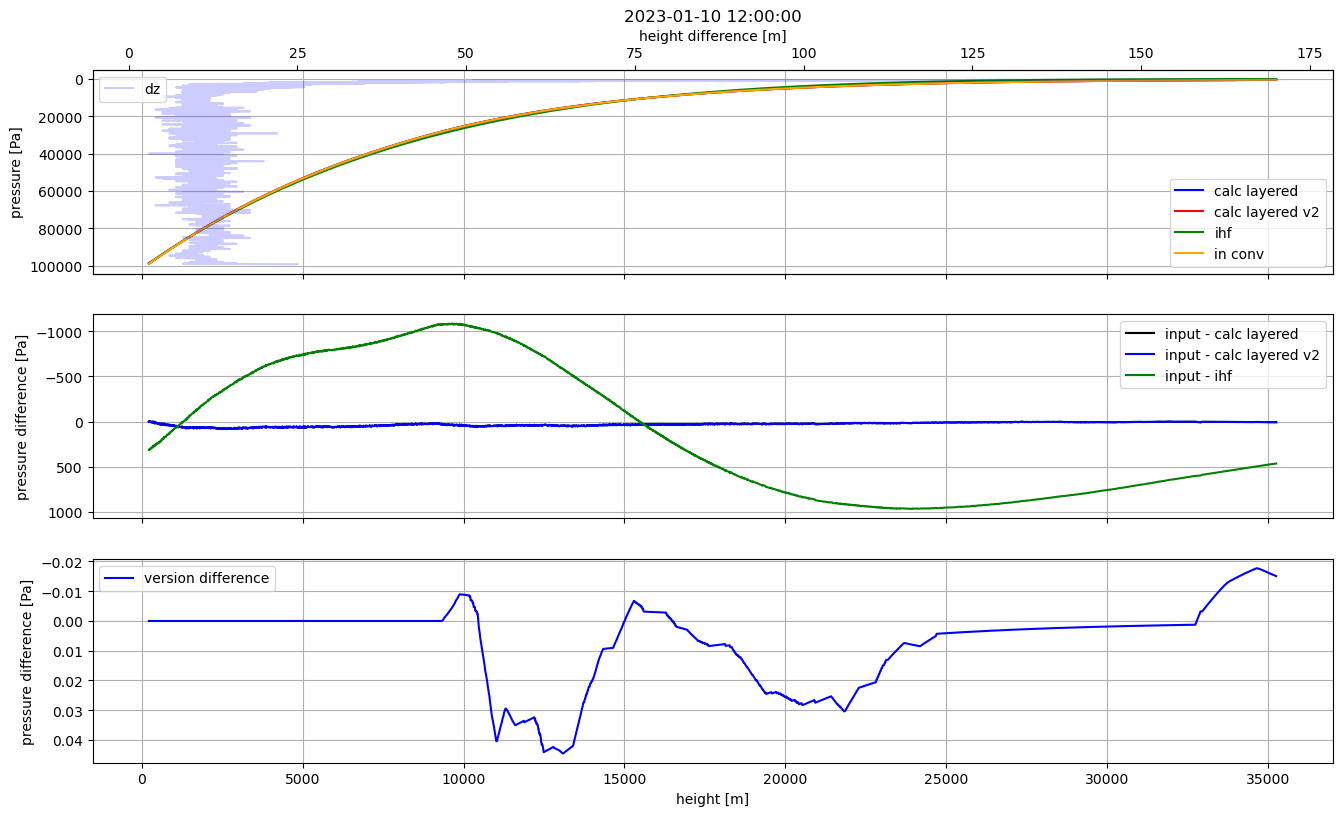

In [3]:
def find_closest_date(dates, target):
    return dates.loc[(dates - target).abs().idxmin()]

def international_height_formula_reverse(z: float) -> float:
    """
    Calculate the pressure (p) in hPa using the reverse of the International Height Formula (IHF).

    Parameters:
    z (float): Height in meters. Must be greater than or equal to 0.

    Returns:
    float: Pressure in hPa.

    Raises:
    ValueError: If the height value is less than 0.
    """
    
    # Constants
    T0 = 288.15  # Standard temperature at sea level in Kelvin
    L = 0.0065   # Temperature lapse rate in K/m
    P0 = 1013.25 # Standard pressure at sea level in hPa
    g0_R = 1 / 5.255

    # Reverse International Height Formula
    p = P0 * (1 - (z * L / T0)) ** (1 / g0_R)
    return p

def calculate_pressure_layered(p0, L, T, z, R=287.053, g=9.80665):
    """
    Calculate the pressure (p) layer by layer for a given atmosphere model.
    
    Parameters:
    - p0: float, pressure at the start of the first layer (in Pascals)
    - L: list of float, temperature lapse rates for each layer (in K/m)
    - z: list of float, thickness of each layer (in meters)
    - T: list of float, temperature at the start of each layer (in Kelvin)
    - R: float, specific gas constant for dry air (default: 287.053 J/(kg·K))
    - g: float, acceleration due to gravity (default: 9.80665 m/s²)
    
    Returns:
    - list of float, pressures at the end of each layer
    """
    p_out = [] 

    exponent = g / (L * R) 

    for i in range(len(z)):
        if i == 0:
            p_out.append(p0)
        else:
            if np.abs(L[i]) > 0.001:  # If L is non-zero, use the polytropic formula
                p_next = p_out[i-1] * (1 - (L[i] * (z[i] - z[i-1])) / T[i-1]) ** exponent[i]
            else:  # If L = 0, use the isothermal layer formula
                p_next = p_out[i-1] * np.exp(-g * (z[i] - z[i-1]) / (R * T[i-1]))
            p_out.append(p_next)
    
    return p_out

def calculate_pressure_layered_v2(p0, L, T, z, R=287.053, g=9.80665):
    """
    Calculate the pressure (p) layer by layer for a given atmosphere model.
    
    Parameters:
    - p0: float, pressure at the start of the first layer (in Pascals)
    - L: list of float, temperature lapse rates for each layer (in K/m)
    - z: list of float, thickness of each layer (in meters)
    - T: list of float, temperature at the start of each layer (in Kelvin)
    - R: float, specific gas constant for dry air (default: 287.053 J/(kg·K))
    - g: float, acceleration due to gravity (default: 9.80665 m/s²)
    
    Returns:
    - list of float, pressures at the end of each layer
    """
    p_out = [] 

    exponent = g / (L * R) 

    for i in range(len(z)):
        if i == 0:
            p_out.append(p0)
        else:
            p_next = p_out[i-1] * (1 - (L[i] * (z[i] - z[i-1])) / T[i-1]) ** exponent[i]
            # if np.abs(L[i]) > 0.001:  # If L is non-zero, use the polytropic formula
            #     p_next = p_out[i-1] * (1 - (L[i] * (z[i] - z[i-1])) / T[i-1]) ** exponent[i]
            # else:  # If L = 0, use the isothermal layer formula
            #     p_next = p_out[i-1] * np.exp(-g * (z[i] - z[i-1]) / (R * T[i]))
            p_out.append(p_next)
    
    return p_out


for date in range(20230101, 20230132)[:10]:

    # Selecting the ascent:

    bg_df = era_df[(era_df.andate == date) & (era_df.antime == 120000)]

    target_date = pd.to_datetime(pd.to_datetime(date, format='%Y%m%d').strftime('%Y-%m-%d') + ' 12:00:00') 
    found_date = find_closest_date(df.date_time, target_date)
    

    # conv_df = df[df.date_time.dt.date == pd.to_datetime('2023-01-01').date()]
    conv_df = df[df.date_time == pd.to_datetime(found_date)]
    conv_df = conv_df.iloc[::-1]

    # Reducing Layers
    # conv_df = conv_df.iloc[::10]

    # Showing dz from the input:

    # Interpolating:

    bg_df = bg_df.sort_values(by = 'gpm')
    bg_df = bg_df.drop_duplicates(['gpm'])
    f_cubic = interp1d(bg_df['gpm'], bg_df['temp_final'], kind='cubic' , fill_value="extrapolate")

    inp_gpm = list(conv_df['observation_value'])
    inp_t = f_cubic(inp_gpm)

    # Calculating the lapse rate:

    lapse = []
    for i in range(1, len(inp_t)):
        dt = inp_t[i] - inp_t[i-1]
        dz = (inp_gpm[i] - inp_gpm[i-1]) / 9.80665
        lapse.append(dt/dz)

    # Calculating the pressure

    calc_p_layered = calculate_pressure_layered(bg_df['vertco_reference_1@body'].iloc[0], np.array(lapse),  np.array(bg_df['temp_final']), np.array(inp_gpm[1:])/ 9.80665)
    calc_p_layered_v2 = calculate_pressure_layered_v2(bg_df['vertco_reference_1@body'].iloc[0], np.array(lapse),  np.array(bg_df['temp_final']), np.array(inp_gpm[1:])/ 9.80665)

    ihf_p = international_height_formula_reverse(np.array(inp_gpm[1:])/ 9.80665) * 100 # Pa -> hPa

    # Plotting

    fig, (ax1, ax3, ax4) = plt.subplots(3, 1, sharex=True, figsize=(16, 9), dpi=100)

    ax1.plot(np.array(inp_gpm[1:])/ 9.80665, calc_p_layered, 'blue', label='calc layered')
    ax1.plot(np.array(inp_gpm[1:])/ 9.80665, calc_p_layered_v2, 'red', label='calc layered v2')
    ax1.plot(np.array(inp_gpm[1:])/ 9.80665, ihf_p, 'green', label='ihf')
    ax1.plot(np.array(inp_gpm[1:])/ 9.80665 , conv_df['z_coordinate'][1:], 'orange', label='in conv')
    ax1.set_ylabel("pressure [Pa]")
    ax1.legend(loc='lower right')
    ax1.grid()

    ax2 = ax1.twiny()

    ax2.plot((np.array(conv_df.observation_value.iloc[1:]) - np.array(conv_df.observation_value.iloc[:-1]))/ 9.80665, conv_df.z_coordinate.iloc[:-1], 'blue', label='dz', alpha=0.2)
    ax2.set_xlabel("height difference [m]")
    ax2.legend(loc='upper left')

    ax3.plot(np.array(inp_gpm[1:])/ 9.80665, conv_df['z_coordinate'][1:] - calc_p_layered, 'black', label='input - calc layered')
    ax3.plot(np.array(inp_gpm[1:])/ 9.80665, conv_df['z_coordinate'][1:] - calc_p_layered_v2, 'blue', label='input - calc layered v2')
    ax3.plot(np.array(inp_gpm[1:])/ 9.80665, conv_df['z_coordinate'][1:] - ihf_p, 'green', label='input - ihf')
    ax3.set_ylabel("pressure difference [Pa]")
    ax3.grid()
    ax3.legend()
    # ax3.legend(loc='center right')


    ax4.plot(np.array(inp_gpm[1:])/ 9.80665, ((conv_df['z_coordinate'][1:] - calc_p_layered) - (conv_df['z_coordinate'][1:] - calc_p_layered_v2)), 'blue', label='version difference')
    ax4.set_ylabel("pressure difference [Pa]")
    ax4.set_xlabel("height [m]")
    ax4.grid()
    ax4.legend()

    ax1.invert_yaxis()
    ax3.invert_yaxis()
    ax4.invert_yaxis()
    plt.title(target_date)
    plt.show()
    plt.close()


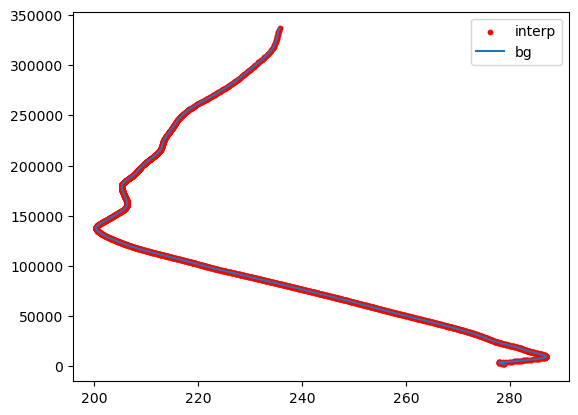

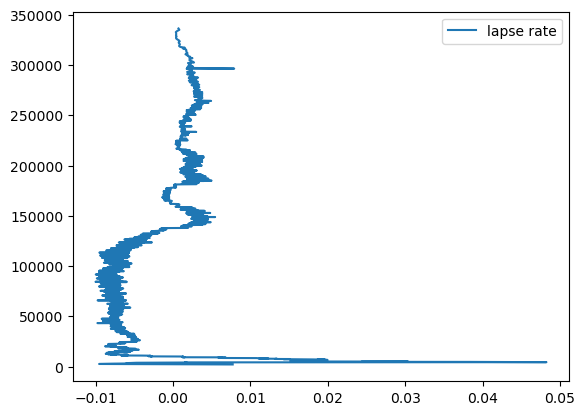

100000.0 98969.28442266484


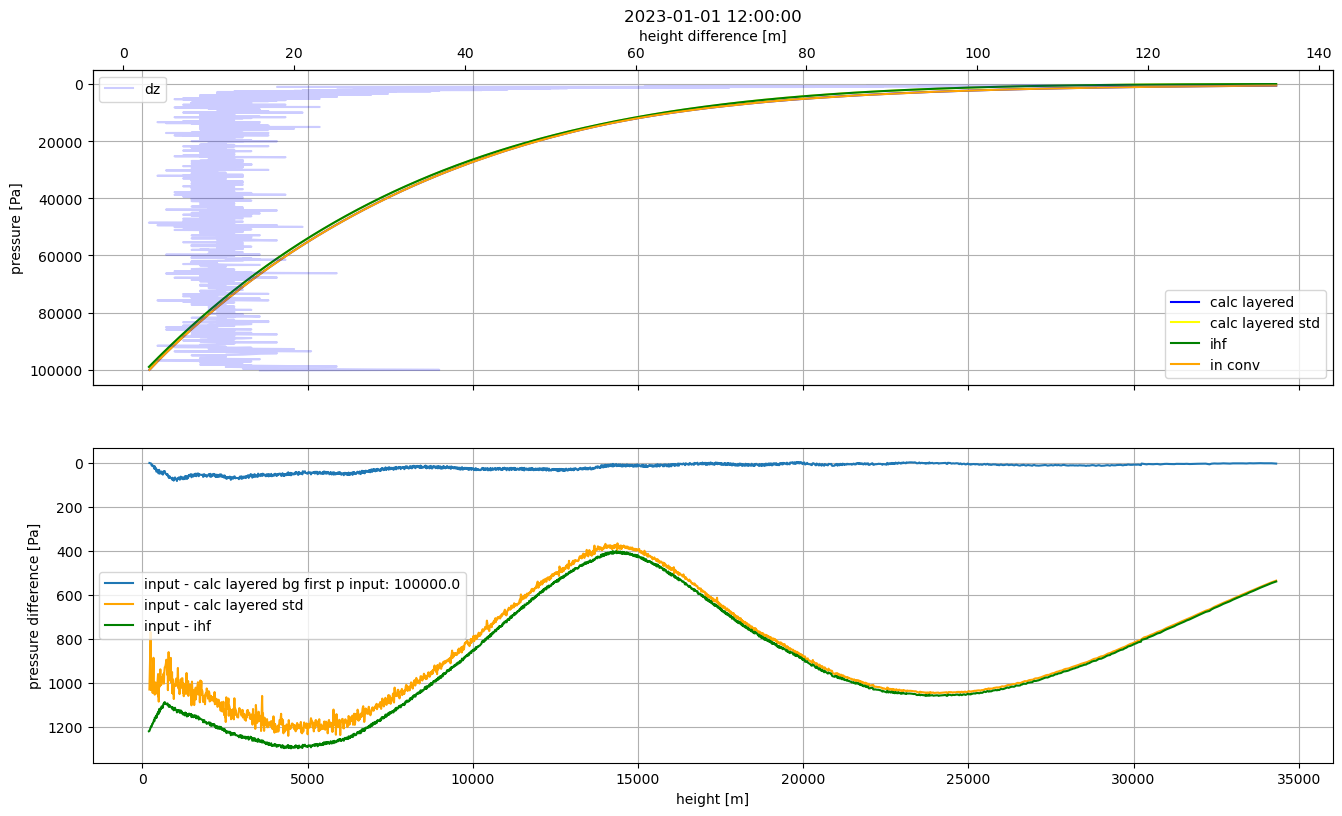

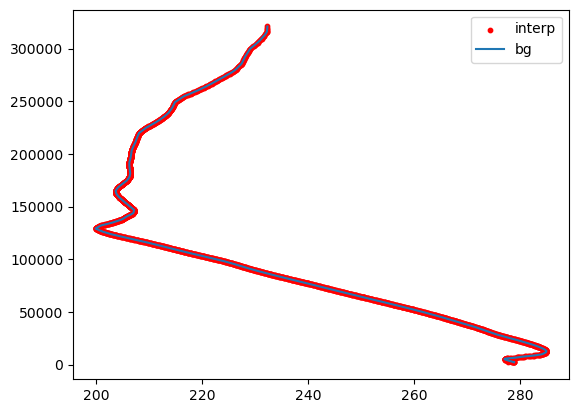

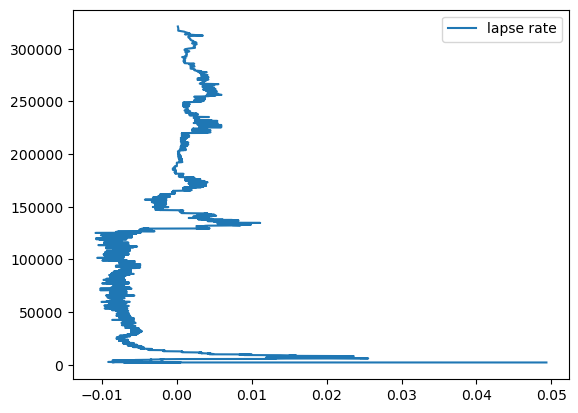

99660.0 98969.28442266484


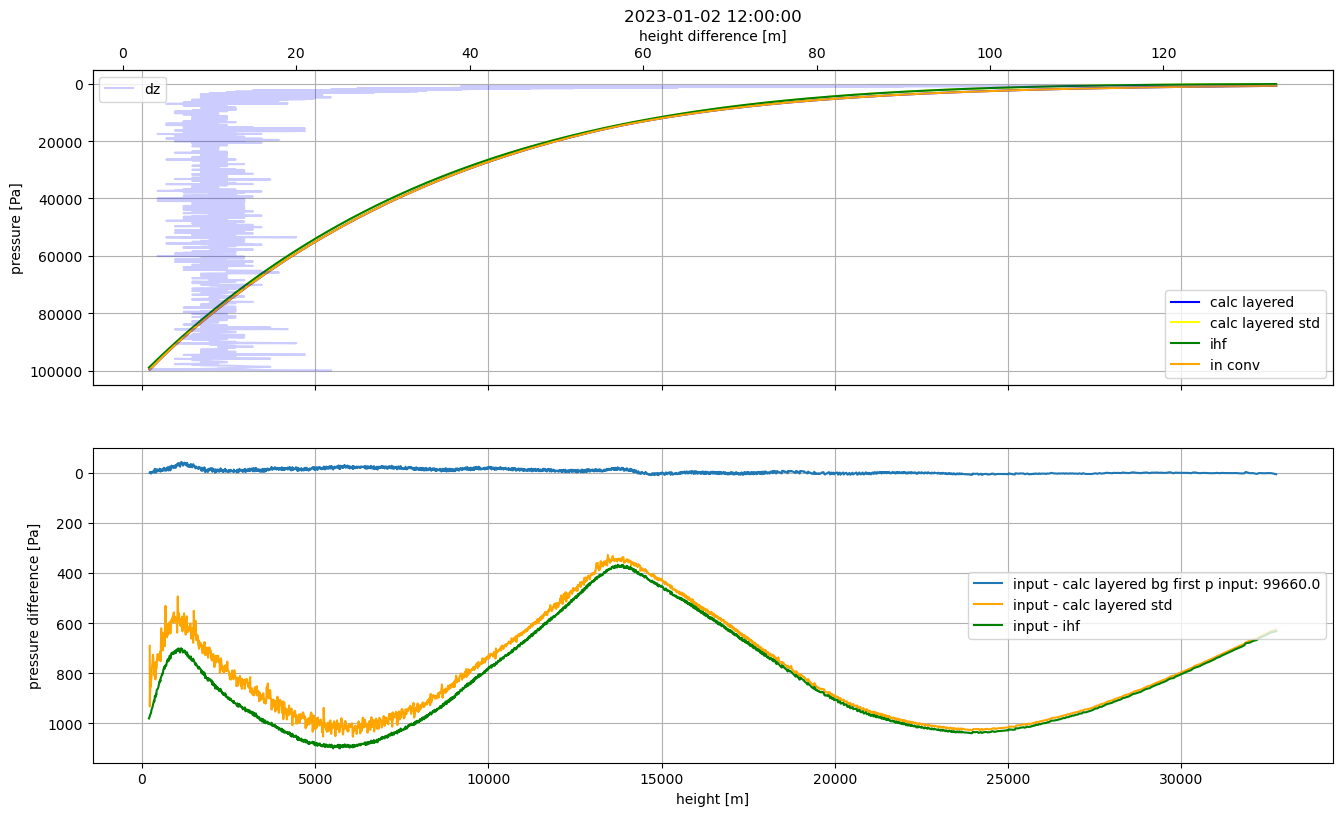

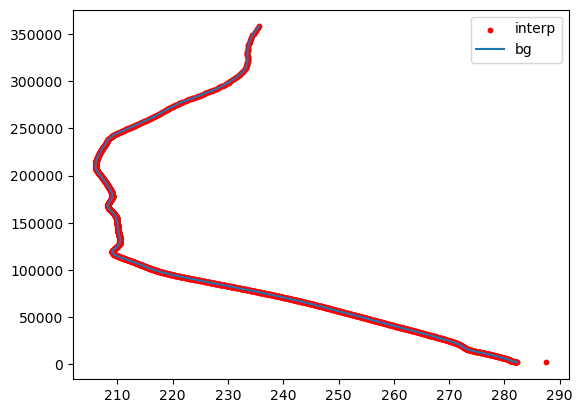

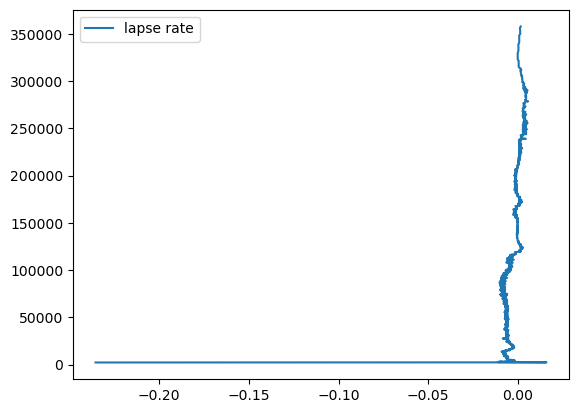

100300.0 98969.28442266484


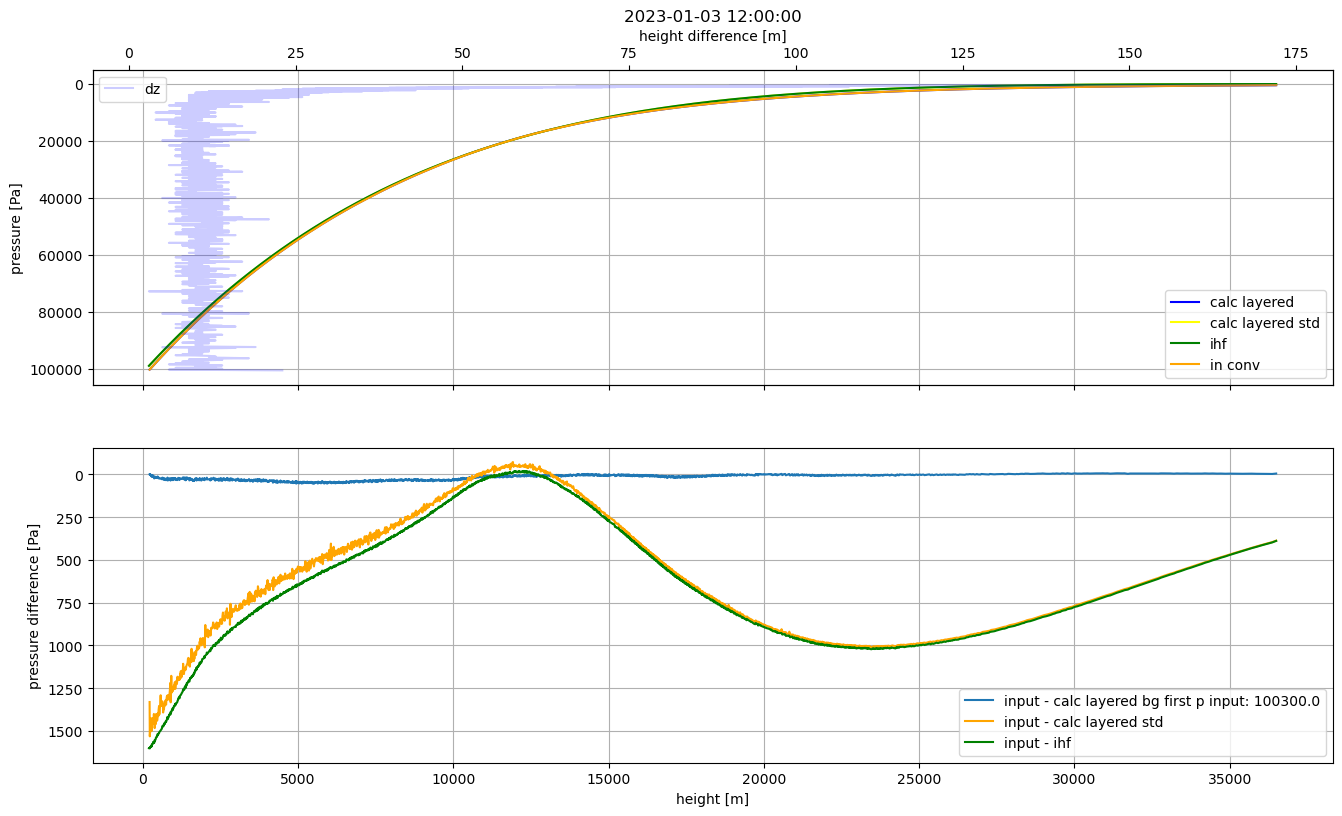

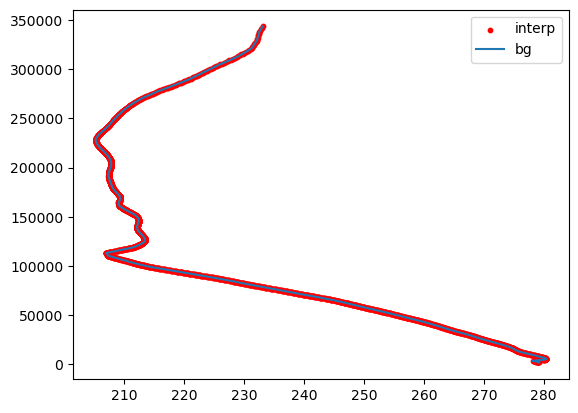

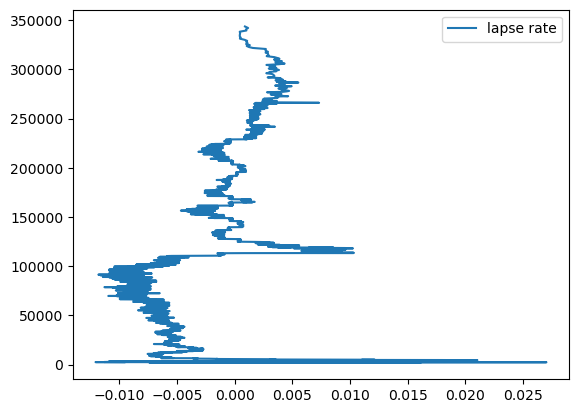

100160.0 98969.28442266484


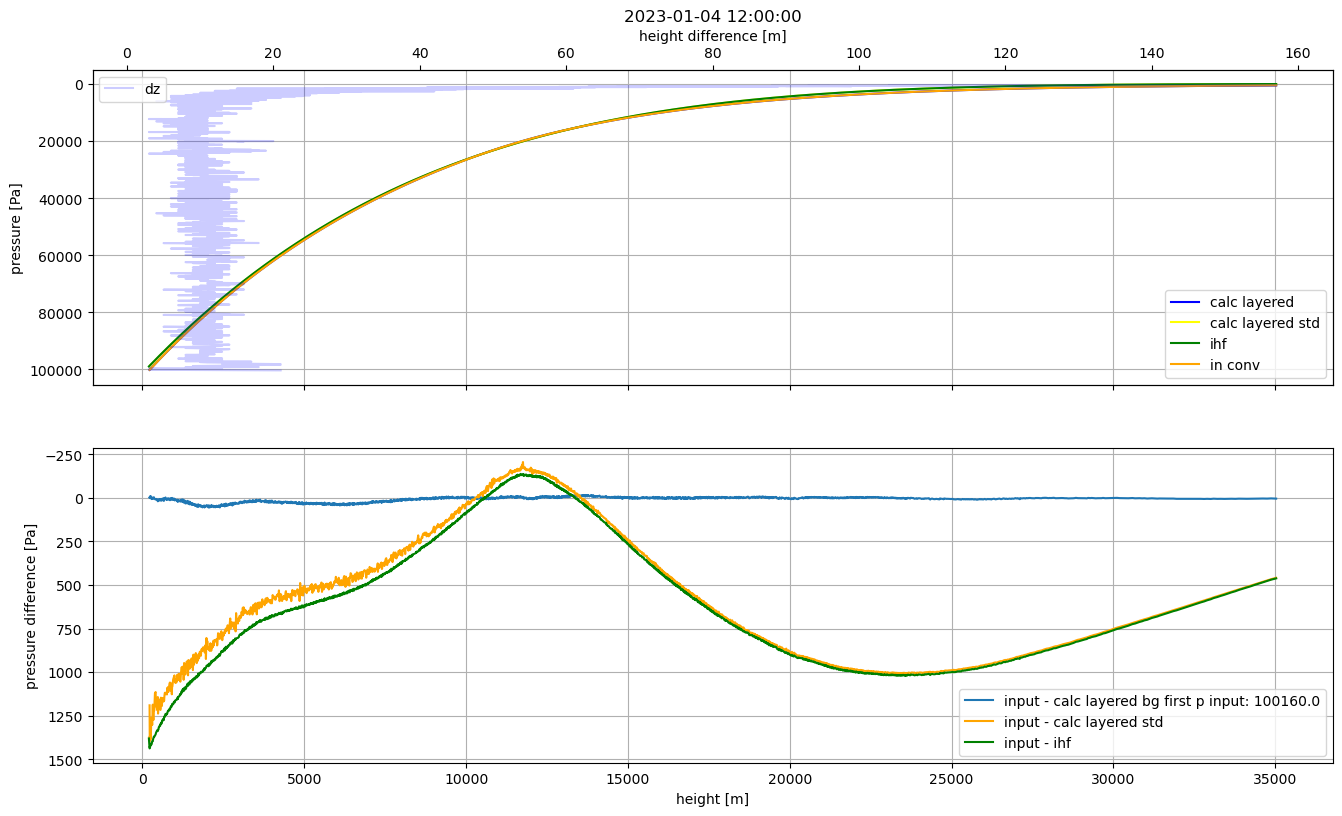

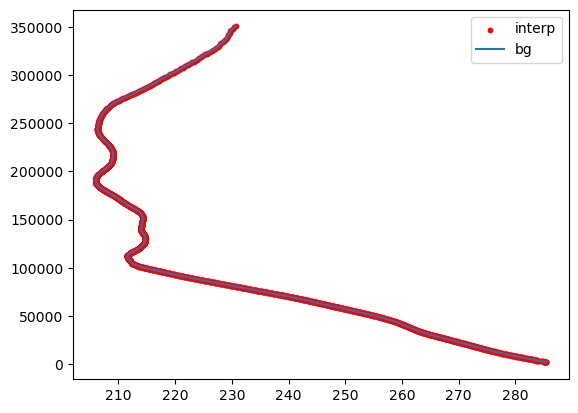

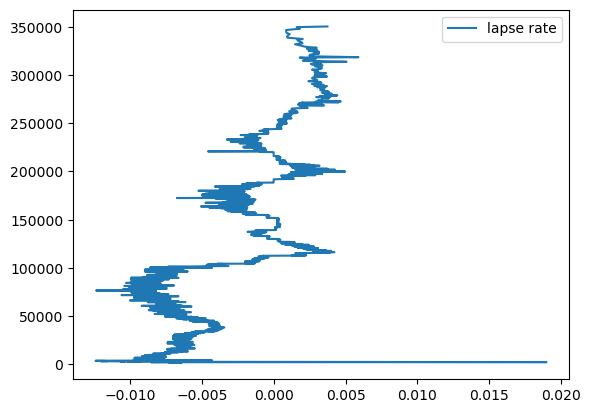

99300.0 98969.28442266484


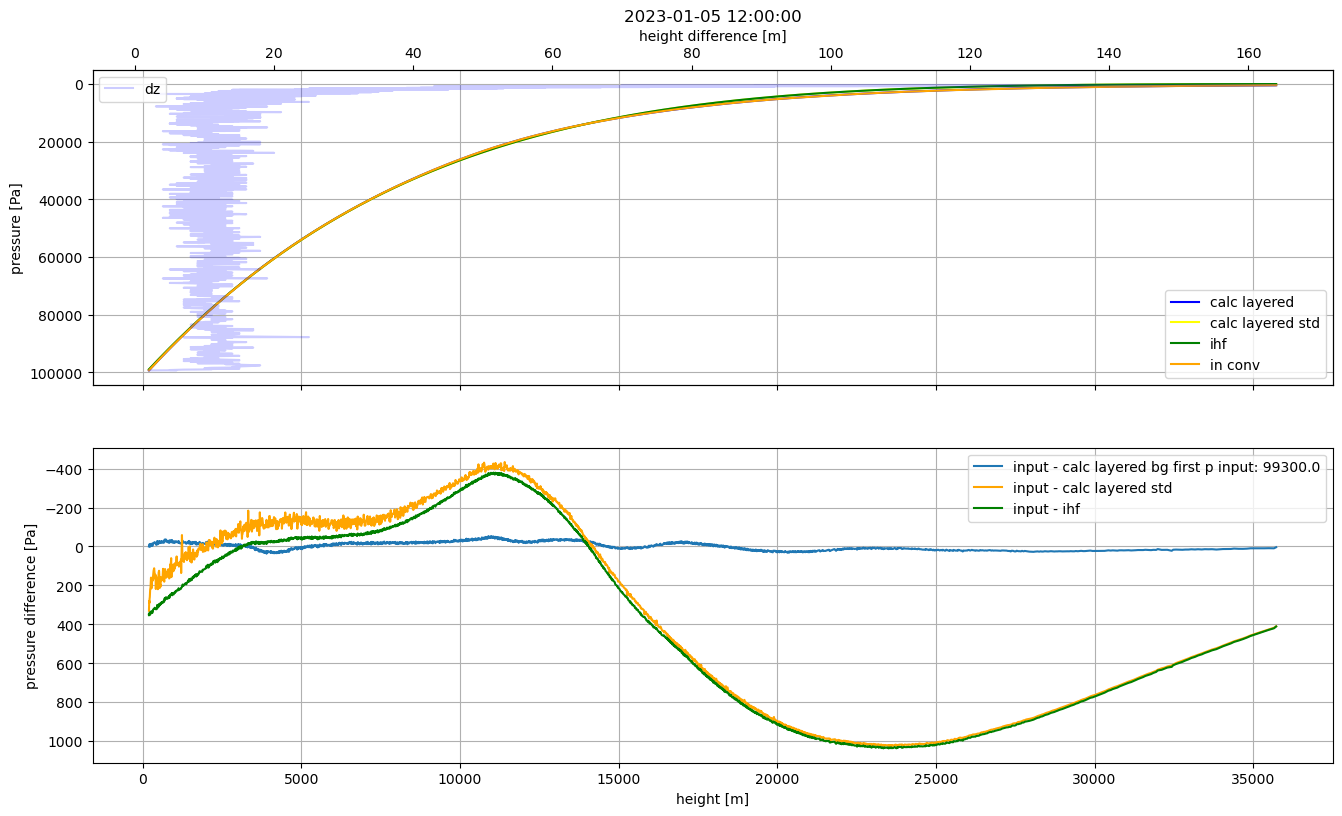

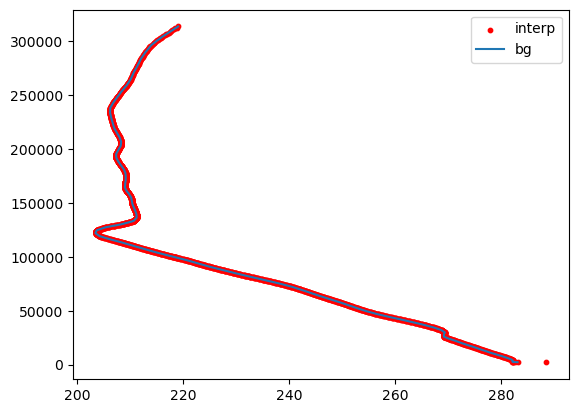

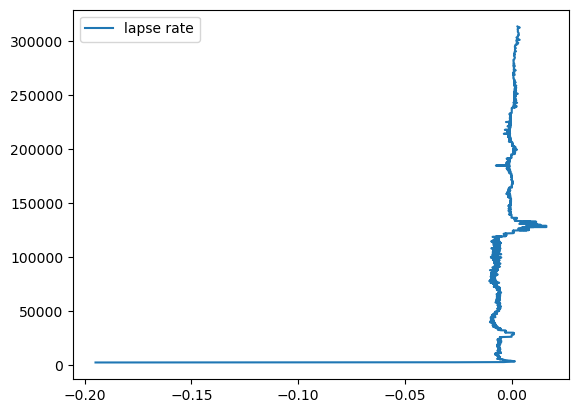

99600.0 98969.28442266484


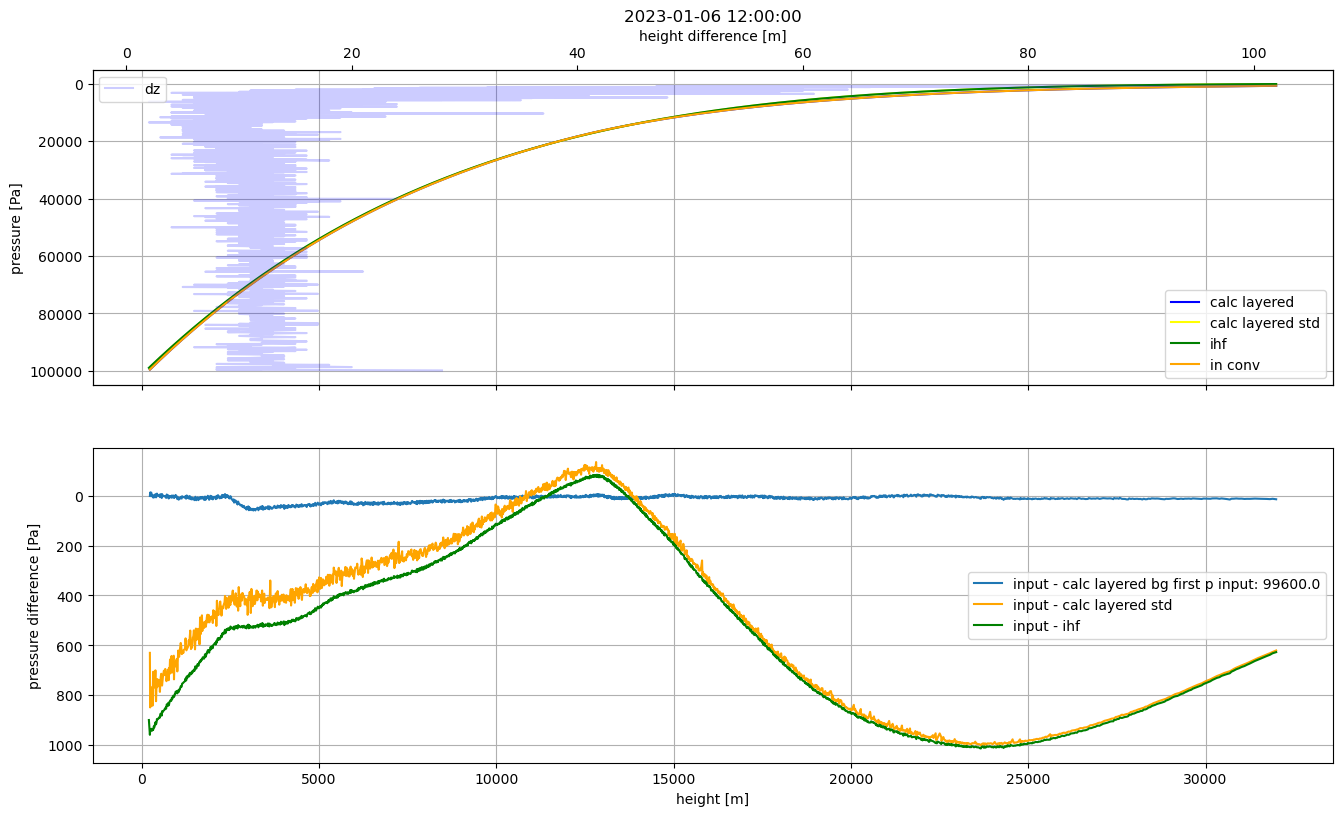

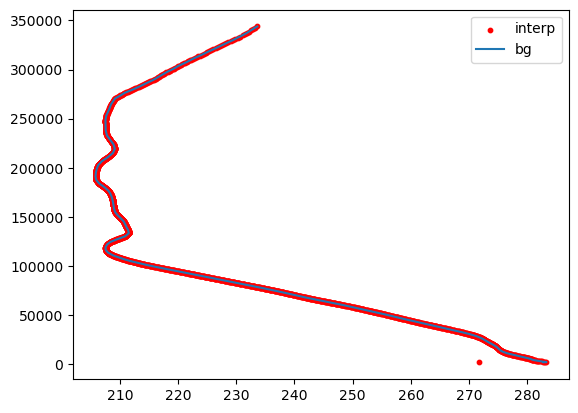

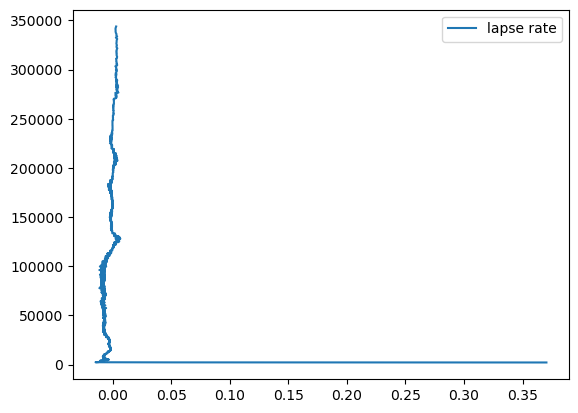

99340.0 98969.28442266484


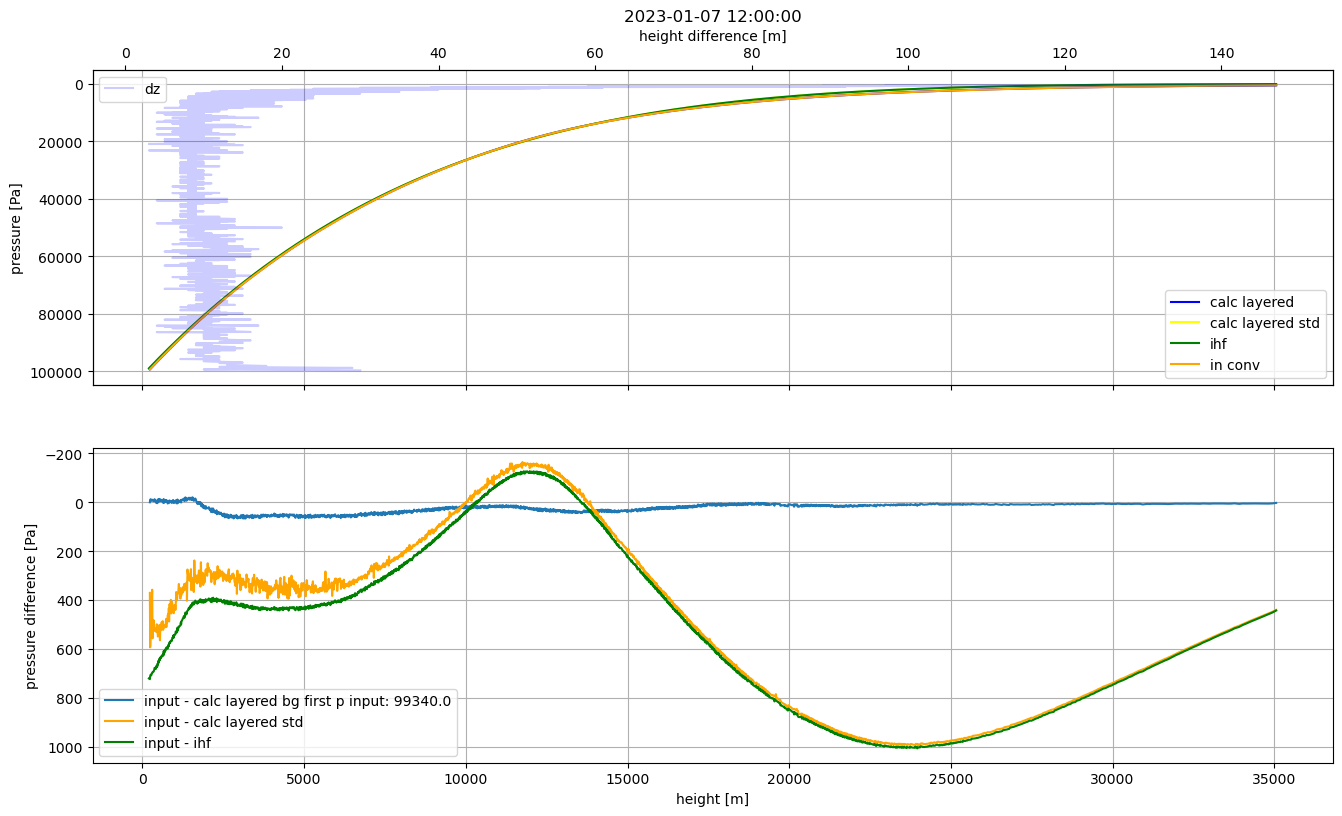

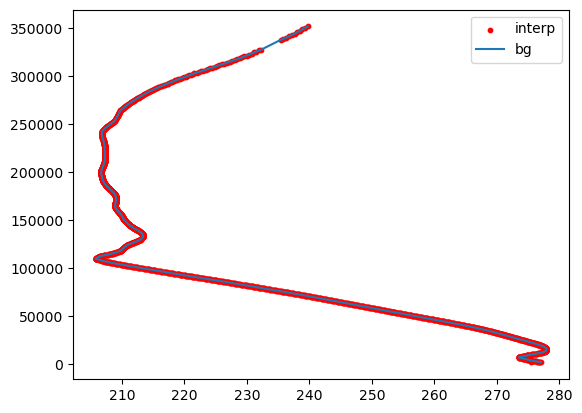

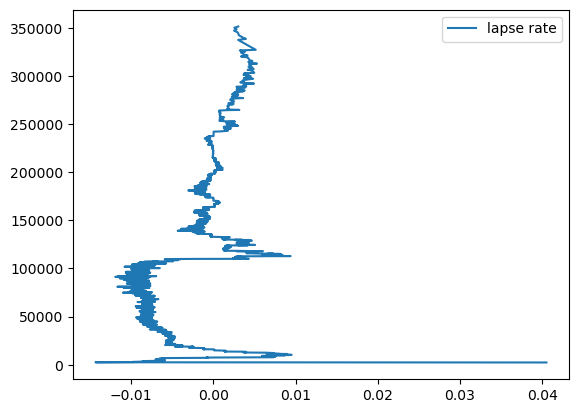

98310.0 98969.28442266484


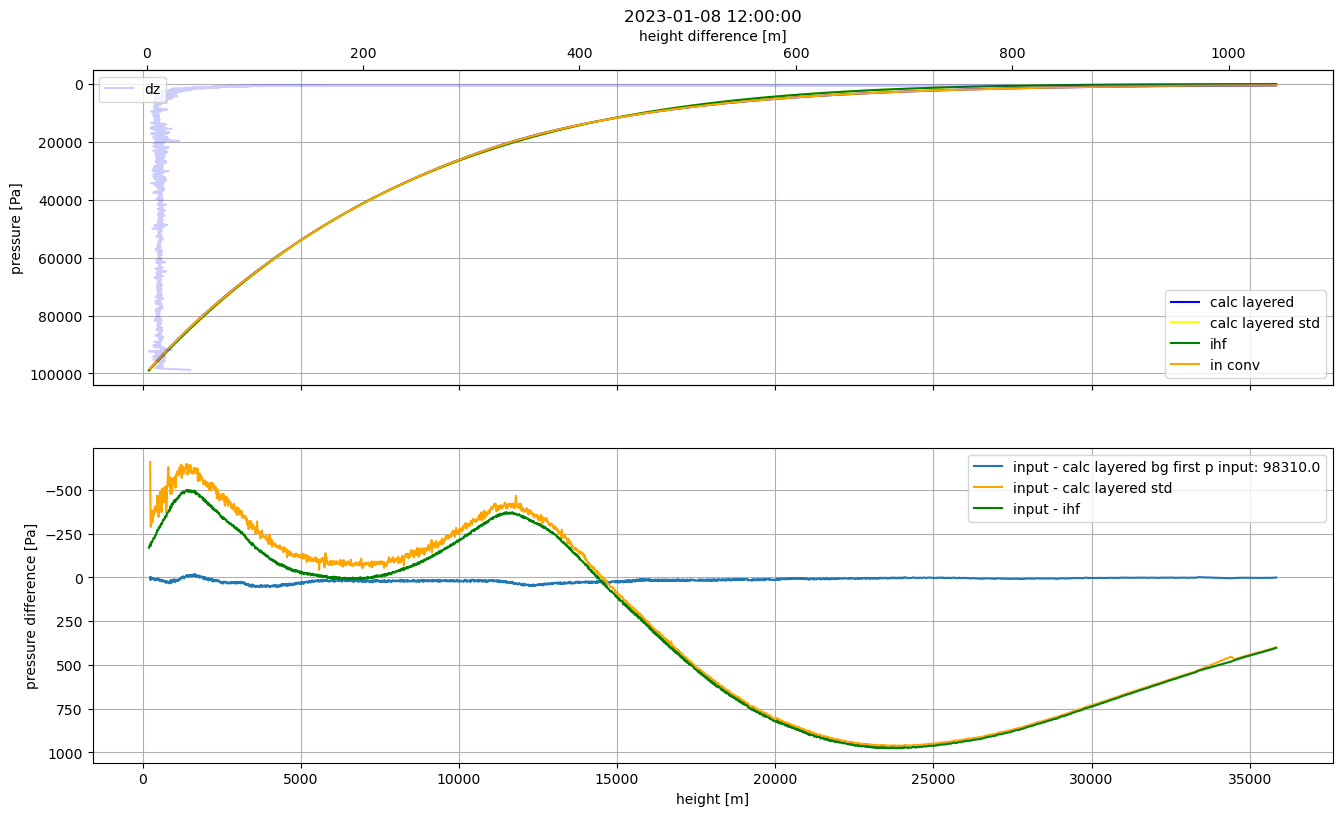

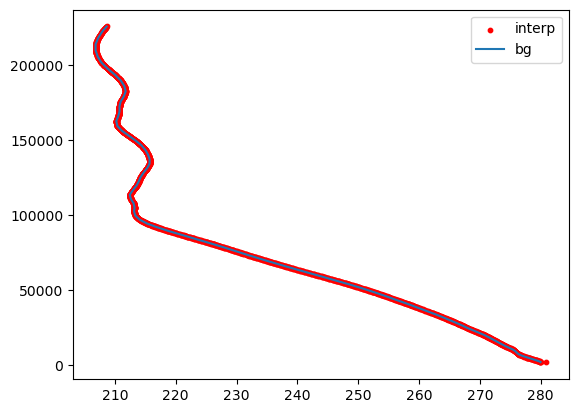

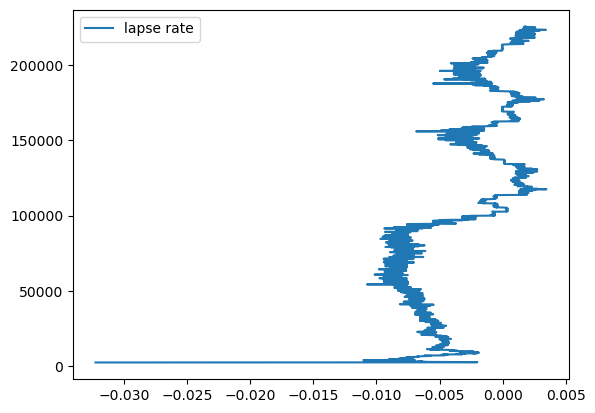

97650.0 98969.28442266484


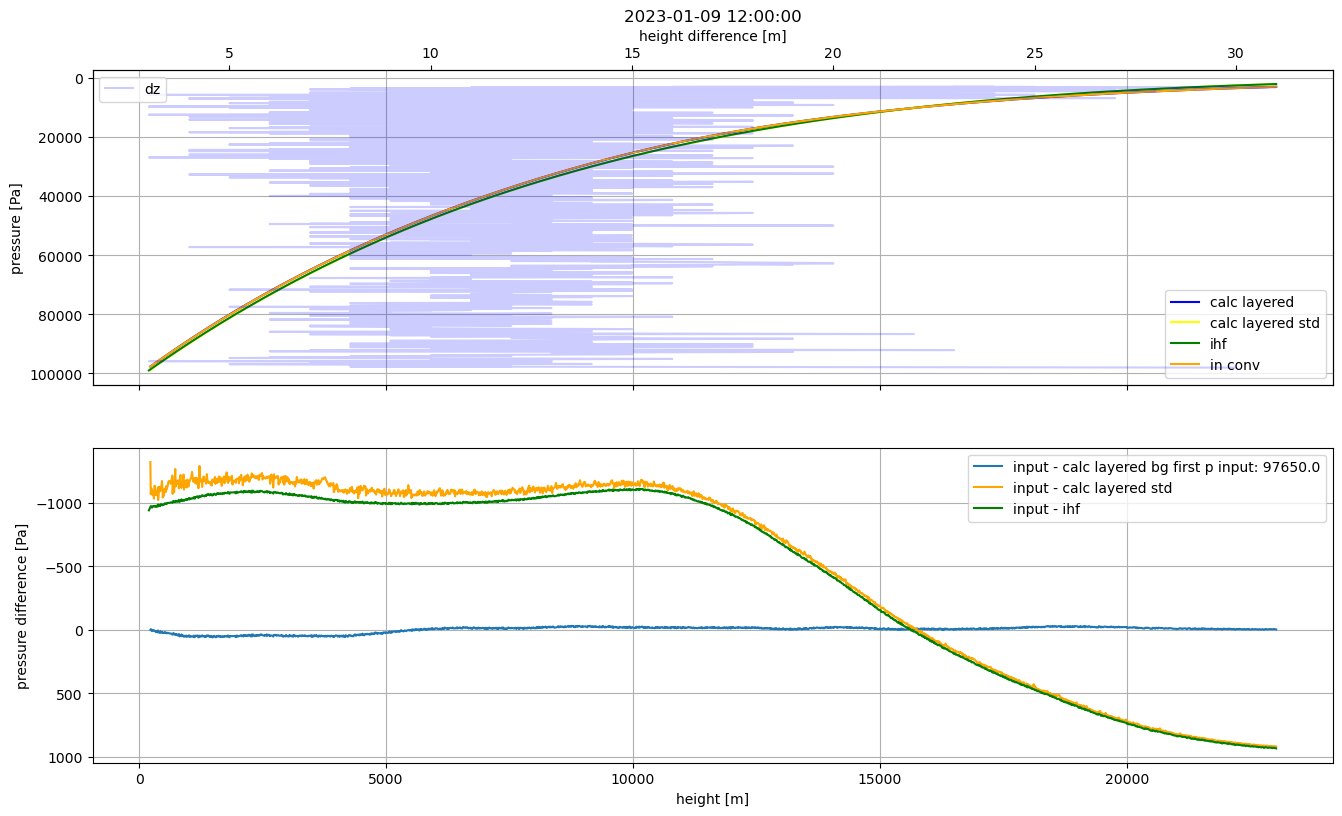

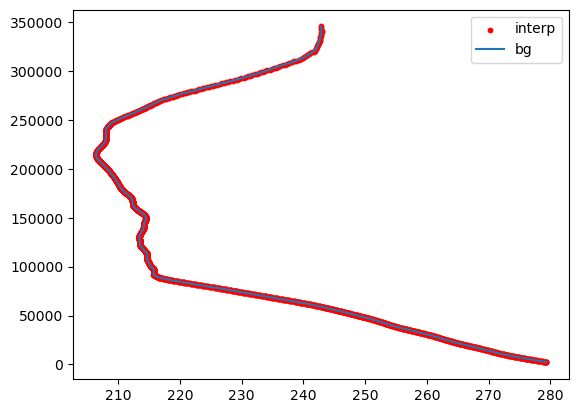

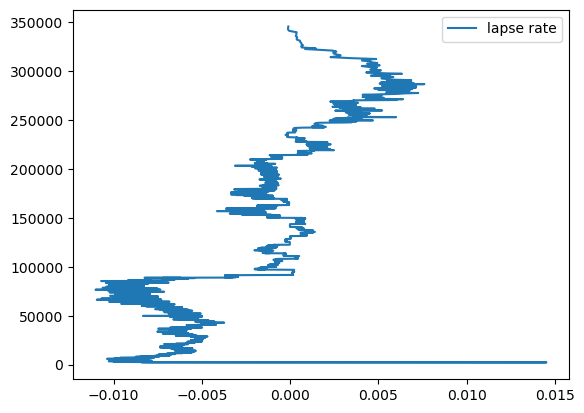

98990.0 98969.28442266484


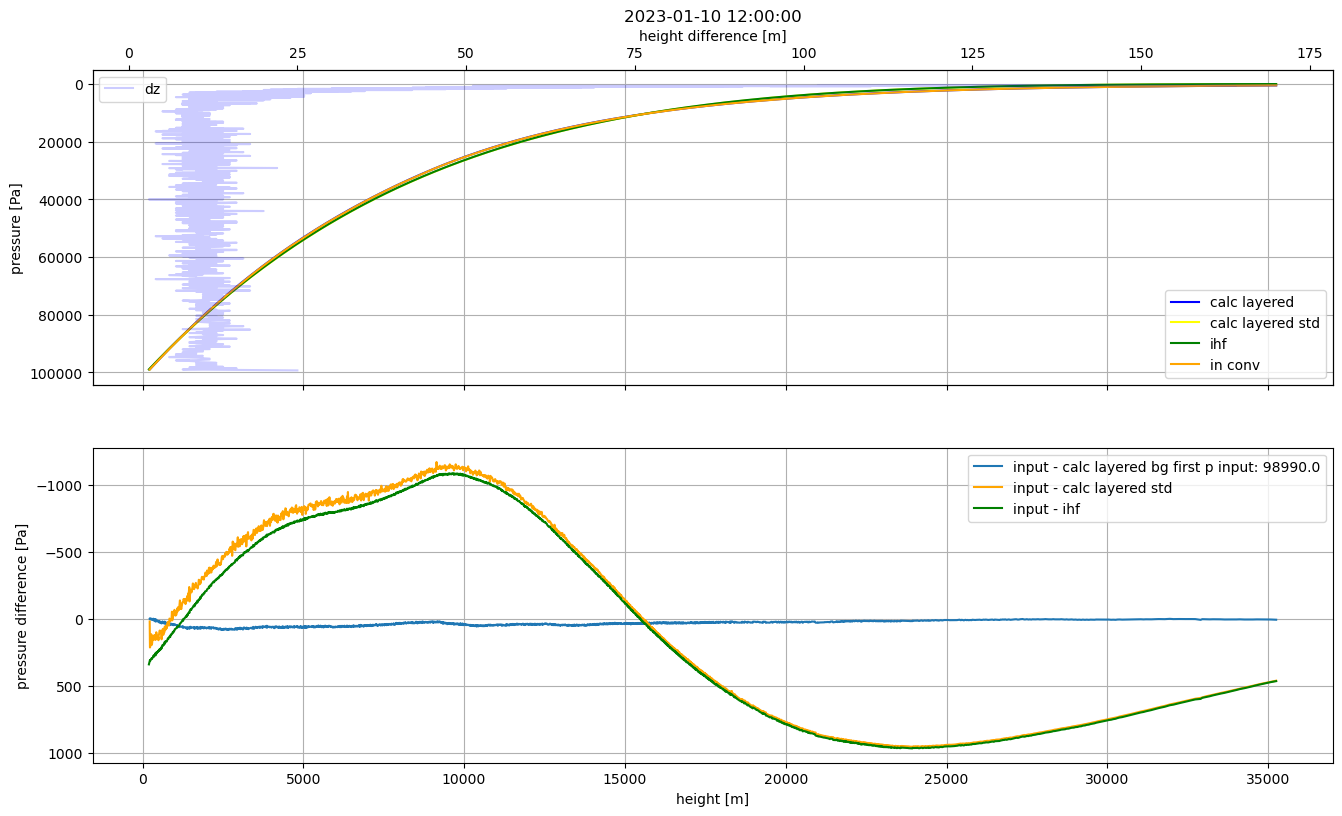

In [16]:
def find_closest_date(dates, target):
    return dates.loc[(dates - target).abs().idxmin()]

for date in range(20230101, 20230132)[:10]:

    # Selecting the ascent:

    bg_df = era_df[(era_df.andate == date) & (era_df.antime == 120000)]

    target_date = pd.to_datetime(pd.to_datetime(date, format='%Y%m%d').strftime('%Y-%m-%d') + ' 12:00:00') 
    found_date = find_closest_date(df.date_time, target_date)


    # conv_df = df[df.date_time.dt.date == pd.to_datetime('2023-01-01').date()]
    conv_df = df[df.date_time == pd.to_datetime(found_date)]
    conv_df = conv_df.iloc[::-1]

    # Reducing Layers
    # conv_df = conv_df.iloc[::10]

    # Interpolating:

    bg_df = bg_df.sort_values(by = 'gpm')
    bg_df = bg_df.drop_duplicates(['gpm'])
    f_cubic = interp1d(bg_df['gpm'], bg_df['temp_final'], kind='cubic' , fill_value="extrapolate")

    inp_gpm = list(conv_df['observation_value'])
    inp_t = f_cubic(inp_gpm)

    plt.scatter(inp_t, inp_gpm, 10, label='interp', color='red')
    plt.plot(bg_df.temp_final, bg_df.gpm, label='bg')
    plt.legend()
    plt.show()
    plt.close()

    # Calculating the lapse rate:

    lapse = []
    for i in range(1, len(inp_t)):
        dt = inp_t[i] - inp_t[i-1]
        dz = (inp_gpm[i] - inp_gpm[i-1]) / 9.80665
        lapse.append(dt/dz)

    plt.plot(lapse, inp_gpm[1:], label='lapse rate')
    plt.legend()
    plt.show()
    plt.close()

    # Calculating the pressure

    
    p0 = international_height_formula_reverse(np.array(inp_gpm[0])/ 9.80665) * 100
    calc_p_layered_std = calculate_pressure_layered(p0, np.array([-0.0065 for i in range(len(np.array(inp_gpm[0:-1])))]),  288.15 + (np.array(inp_gpm[:-1])/ 9.80665 ) * -0.0065, np.array(inp_gpm[:-1])/ 9.80665)

    # calc_p_layered = calculate_pressure_layered(bg_df['vertco_reference_1@body'].iloc[0], np.array(lapse),  np.array(bg_df['temp_final']), np.array(inp_gpm[1:])/ 9.80665)
    print(bg_df['vertco_reference_1@body'].iloc[0], p0)
    calc_p_layered_1 = calculate_pressure_layered(bg_df['vertco_reference_1@body'].iloc[0], np.array(lapse),  np.array(bg_df['temp_final']), np.array(inp_gpm[1:])/ 9.80665)
    # calc_p_layered_3 = calculate_pressure_layered(100000, np.array(lapse),  np.array(bg_df['temp_final']), np.array(inp_gpm[1:])/ 9.80665)

    ihf_p = international_height_formula_reverse(np.array(inp_gpm[:])/ 9.80665) * 100 # Pa -> hPa

    # Plotting

    fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(16, 9), dpi=100)

    z_input = np.array(inp_gpm[1:])/ 9.80665
    z_input_full = np.array(inp_gpm[:])/ 9.80665

    ax1.plot(z_input, calc_p_layered_1, 'blue', label='calc layered')
    ax1.plot(z_input, calc_p_layered_std, 'yellow', label='calc layered std')
    
    ax1.plot(z_input_full, ihf_p, 'green', label='ihf')
    ax1.plot(z_input , conv_df['z_coordinate'][1:], 'orange', label='in conv')
    ax1.set_ylabel("pressure [Pa]")
    ax1.legend(loc='lower right')
    ax1.grid()

    ax2 = ax1.twiny()

    ax2.plot((np.array(conv_df.observation_value.iloc[1:]) - np.array(conv_df.observation_value.iloc[:-1]))/ 9.80665, conv_df.z_coordinate.iloc[:-1], 'blue', label='dz', alpha=0.2)
    ax2.set_xlabel("height difference [m]")
    ax2.legend(loc='upper left')

    ax3.plot(z_input, conv_df['z_coordinate'][1:] - calc_p_layered_1, label='input - calc layered bg first p input: ' + str(bg_df['vertco_reference_1@body'].iloc[0]))
    # ax3.plot(z_input, conv_df['z_coordinate'][1:] - calc_p_layered_3, label='input - calc layered 1000 hpa input')
    ax3.plot(z_input, conv_df['z_coordinate'][1:] - calc_p_layered_std, 'orange', label='input - calc layered std')
    ax3.plot(z_input_full, conv_df['z_coordinate'][:] - ihf_p[:], 'green', label='input - ihf')
    ax3.set_ylabel("pressure difference [Pa]")
    ax3.grid()
    ax3.legend()
    ax3.set_xlabel("height [m]")

    ax1.invert_yaxis()
    ax3.invert_yaxis()
    plt.title(target_date)
    plt.show()
    plt.close()


In [17]:
# delta T per level ?
# take pressure directly from bg? no calc just inter p.? Less levels? 